# Prolog

In [22]:
import pandas as pd
import seaborn as sb
import os
import OHCParser as op
import datetime
import traceback
from scipy.optimize import curve_fit
import pathlib

In [23]:
dfs = op.read_submissions()
dfs = op.derive_metrics(dfs)

last time the data was updated 2025-09-05 13:41:16.846264  by  sles
03_OHC1_DrivAer_Result_Template_v3 Ruggero Poletto.xlsm: No energy data found


/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


10_Olenik_OHC1_FTP_S_MILAN250_CPU.xlsm: No energy data found
08_OHC1_DrivAer_Result_inductiva_65M Gabriel Marcos Magalhães.xlsm: No energy data found
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: number of timestep != number of wall clock time, assuming partial run
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: trying to fill wct, this makes only sense if N/A cases are contiguously to the right at the moment
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: No energy data found


In [24]:
# Serialize forces we try to read in all even if most of them fail
_,_,fs = next(os.walk("submissions"))

dfsf = pd.DataFrame()
for fn in fs:
    if not fn.endswith("xlsm"):
        continue
    try:
        df_meta = pd.read_excel("submissions/" + fn, sheet_name="META Data")
        df_forces = pd.read_excel("submissions/" + fn, sheet_name="Aero Forces")
        dft=op.serialize_forces(df_forces, df_meta, fn)
    except Exception as e:
        print(f"failed force serialization {fn}")
        print(traceback.format_exc())
    dfsf = pd.concat([dfsf,dft])

/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [25]:
df_hardware = dfs[dfs["Track"] == "Hardware Track"]
df_software = dfs[dfs["Track"] == "Software Track"]

fig_folder = "figures_swtrack"
doSaveFig = False  # Set to True to save figures

In [26]:
# olympic swimming pool 50m*25m*2m 2.5e6 l water
V = 2.5e6 #l water
cp = 4.184  # kJ / kg⋅K
dT = 80 #K,
rho = 1 #kg/l
# 1kJ = 0.0002778 kWh
e = V * rho * dT * cp * 0.0002778

In [27]:
dfs.columns

Index(['Contributor Affiliation', 'File Name', 'Run Wall-Clock Time [s]',
       'Pre-Processing Wall-Clock Time [s]', 'Storage File-System',
       'Number of CPU Cores', 'Number of GPU Devices', 'Number of Nodes',
       'CPU Family', 'CPU Model', 'CPU Submodel', 'CPU Generation',
       'GPU Model', 'Mesh', 'System TDP [W]', 'Number of Cells',
       'Time per Iteration [s]', 'Track', 'OpenFOAM Flavor',
       'Run Consumed Energy [kWh]', 'Decomposition Method', 'Last-Level Cache',
       'Network Interconnect', 'Renumbering Method', 'Contributor ID',
       'Is Partial', 'Is Energy Reported', 'Software Optimization Category',
       'Total Core Time [s]', 'Total Node Time [s]',
       'Energy per Iteration [J]', 'Energy per Iteration [kJ]',
       'Energy-To-Solution [kWh]', 'Time-To-Solution [h]',
       'Core-Time-To-Solution [h]', 'Node-Time-To-Solution [h]', 'FVOPS',
       'FVOPS per Energy', 'FVOPS per Energy per Iteration', 'FVOPS per Node'],
      dtype='object')

In [28]:
df_software["Type"] = "Other"
df_software.loc[df_software["Contributor Affiliation"] == "Cineca", "Type"] = "Full GPU port"
df_software.loc[df_software["Contributor Affiliation"] == "Engys", "Type"] = "Full GPU port"
df_software.loc[df_software["Contributor Affiliation"] == "KIT/TUM", "Type"] = "GPU Plugin"
df_software_fine = df_software[df_software["Mesh"]=="fine"]
df_hardware_fine = df_hardware[df_hardware["Mesh"]=="fine"]


df_software.columns

/tmp/ipykernel_893593/4055474467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_software["Type"] = "Other"


Index(['Contributor Affiliation', 'File Name', 'Run Wall-Clock Time [s]',
       'Pre-Processing Wall-Clock Time [s]', 'Storage File-System',
       'Number of CPU Cores', 'Number of GPU Devices', 'Number of Nodes',
       'CPU Family', 'CPU Model', 'CPU Submodel', 'CPU Generation',
       'GPU Model', 'Mesh', 'System TDP [W]', 'Number of Cells',
       'Time per Iteration [s]', 'Track', 'OpenFOAM Flavor',
       'Run Consumed Energy [kWh]', 'Decomposition Method', 'Last-Level Cache',
       'Network Interconnect', 'Renumbering Method', 'Contributor ID',
       'Is Partial', 'Is Energy Reported', 'Software Optimization Category',
       'Total Core Time [s]', 'Total Node Time [s]',
       'Energy per Iteration [J]', 'Energy per Iteration [kJ]',
       'Energy-To-Solution [kWh]', 'Time-To-Solution [h]',
       'Core-Time-To-Solution [h]', 'Node-Time-To-Solution [h]', 'FVOPS',
       'FVOPS per Energy', 'FVOPS per Energy per Iteration', 'FVOPS per Node',
       'Type'],
      dtype='obje

# General

In [29]:
# some statistics
print(f"""
total number of valid entries: {len(df_software)} / {len(dfs)},
Contributor ID: {set(df_software["Contributor ID"])}  ,
software track entries {len(df_software)} ,
processesed {len(set(dfs['CPU Model']))} different CPU vendors {set(dfs['CPU Model'])},
processesed {len(set(dfs['GPU Model']))} different GPUmodels {set(dfs['GPU Model'])},
-------------------
break-down by CPU model: {dfs["CPU Model"].value_counts()}
-------------------
-------------------
break-down by GPUmodel: {dfs["GPU Model"].value_counts()}
-------------------
max nodes {max(dfs['Number of Nodes'])},
max cores {max(dfs['Number of CPU Cores'])},
min wall clc {min(dfs['Run Wall-Clock Time [s]'])},
min time step software {min(df_software['Time per Iteration [s]'])},
min time step hardware {min(df_hardware['Time per Iteration [s]'])},
min energy software {min(df_software['Energy per Iteration [J]'])} [Ws],
min energy hardware {min(df_hardware['Energy per Iteration [J]'])} [Ws],
max FVOPS {max(df_software['FVOPS'])/1e6} [MFVOPS],
max FVOPS {max(df_hardware['FVOPS'])/1e6} [MFVOPS],
max energy {max(dfs['Energy-To-Solution [kWh]'])} [kWh],
total reported energy consumption {sum(dfs['Energy-To-Solution [kWh]'])} kWh, bringing {sum(dfs['Energy-To-Solution [kWh]'])/e} olympic swimming pools worth of water to a boil
decomposition methods {set(dfs["Decomposition Method"])},
renumbering methods {set(dfs["Renumbering Method"])}
network {set(dfs["Network Interconnect"])},
""")


total number of valid entries: 62 / 237,
Contributor ID: {'05', '01', '10', '04', '15'}  ,
software track entries 62 ,
processesed 7 different CPU vendors {'LX2', 'Core', 'Xeon', 'Fujitsu', 'EPYC', 'Neoverse', 'Instinct'},
processesed 4 different GPUmodels {'NVIDIA A100-40', 'N/A', 'NVIDIA A100-64', 'AMD MI100'},
-------------------
break-down by CPU model: CPU Model
EPYC        106
Xeon         79
LX2          25
Fujitsu      18
Neoverse      7
Instinct      1
Core          1
Name: count, dtype: int64
-------------------
-------------------
break-down by GPUmodel: GPU Model
N/A               227
NVIDIA A100-64      6
NVIDIA A100-40      3
AMD MI100           1
Name: count, dtype: int64
-------------------
max nodes 256,
max cores 32768,
min wall clc 0.0,
min time step software 0.116968,
min time step hardware 0.3748,
min energy software 1867.34275 [Ws],
min energy hardware 2613.0 [Ws],
max FVOPS 737.5863598356426 [MFVOPS],
max FVOPS 629.6691568836712 [MFVOPS],
max energy 236.86655999

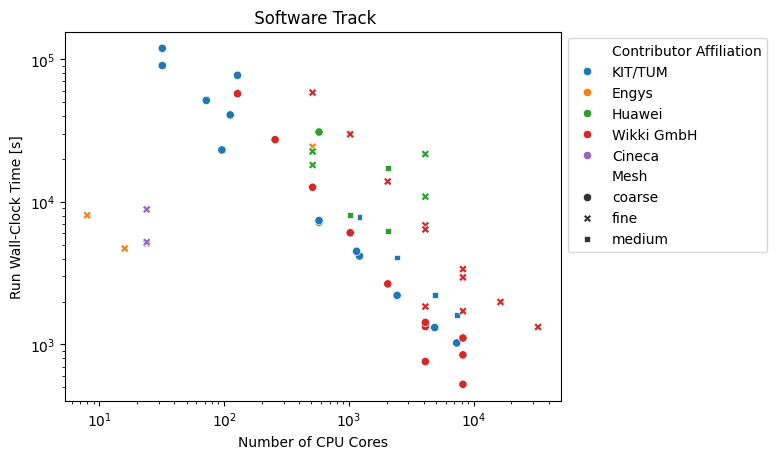

In [30]:
ax = sb.scatterplot(df_software,x="Number of CPU Cores", y="Run Wall-Clock Time [s]", hue="Contributor Affiliation", style="Mesh")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "wct_cores_mesh", doSaveFig)

# FVOPS

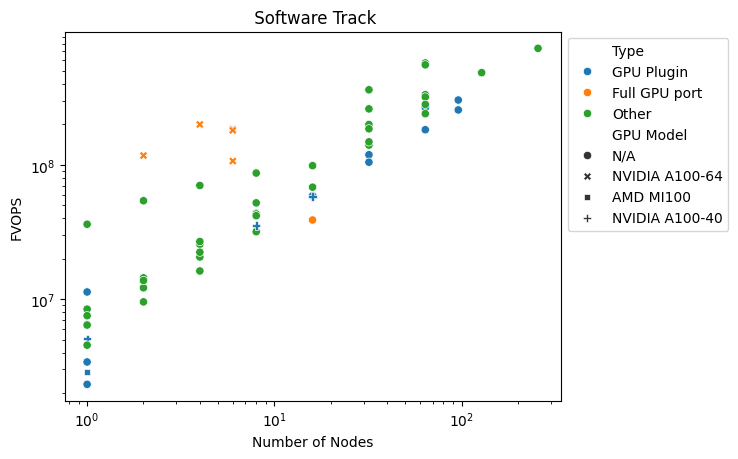

In [31]:
ax = sb.scatterplot(df_software,x="Number of Nodes", y="FVOPS", hue="Type", style="GPU Model")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPS_Nodes_GPUOptimizationType", doSaveFig)

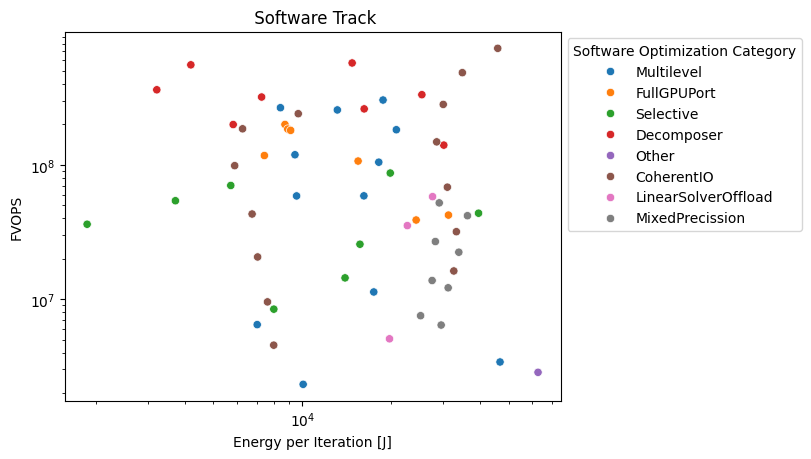

In [32]:
ax = sb.scatterplot(df_software,x="Energy per Iteration [J]", y="FVOPS", hue="Software Optimization Category")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPS_Energy_OptimizationCat", doSaveFig)

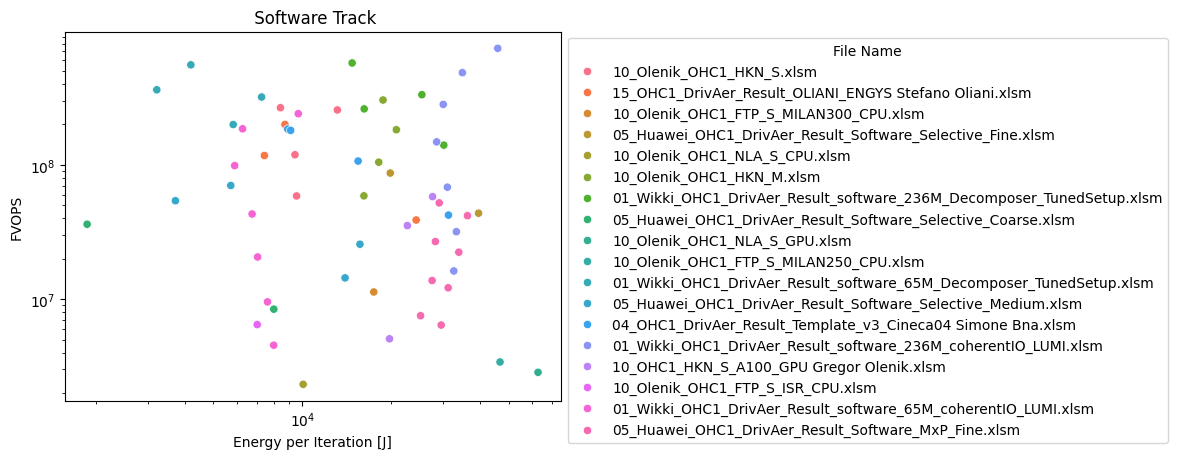

In [33]:
ax = sb.scatterplot(df_software,x="Energy per Iteration [J]", y="FVOPS", hue="File Name")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPS_EnergyPerIteration_FileName", doSaveFig)

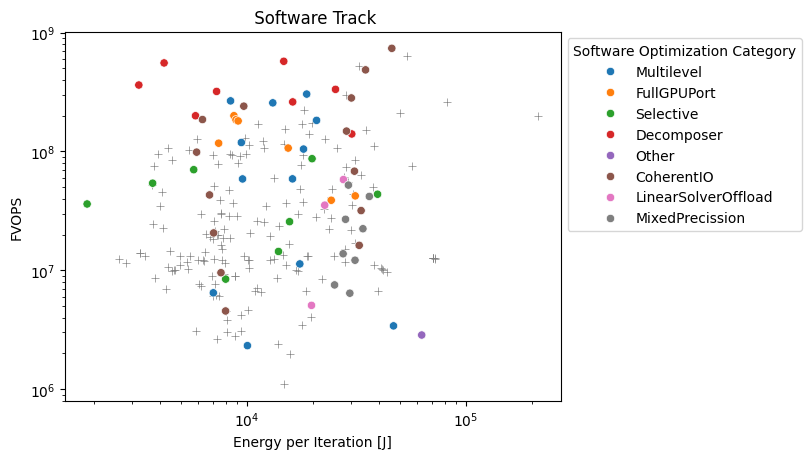

In [34]:
ax = sb.scatterplot(df_hardware,x="Energy per Iteration [J]", y="FVOPS", color="gray", marker="+")
ax = sb.scatterplot(df_software,x="Energy per Iteration [J]", y="FVOPS", hue="Software Optimization Category")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPS_EnergyPerIteration_withHWTrack", doSaveFig)

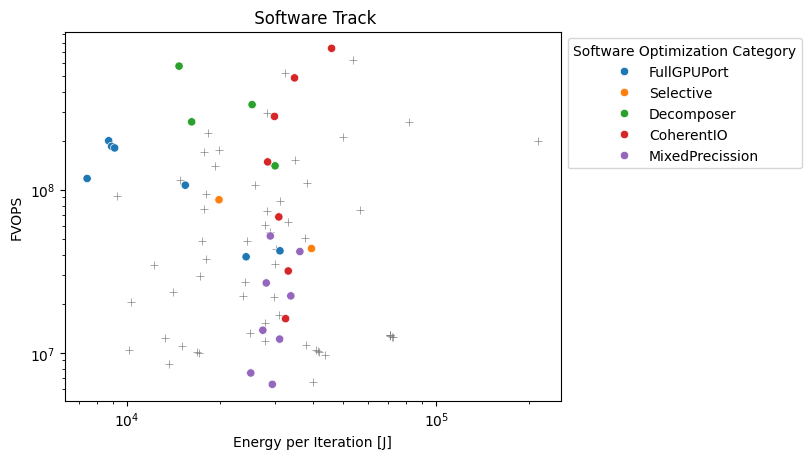

In [35]:
ax = sb.scatterplot(df_hardware_fine,x="Energy per Iteration [J]", y="FVOPS", color="gray", marker="+")
ax = sb.scatterplot(df_software_fine,x="Energy per Iteration [J]", y="FVOPS", hue="Software Optimization Category")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPSEnergyPerIterationFine", doSaveFig)

# Scaling

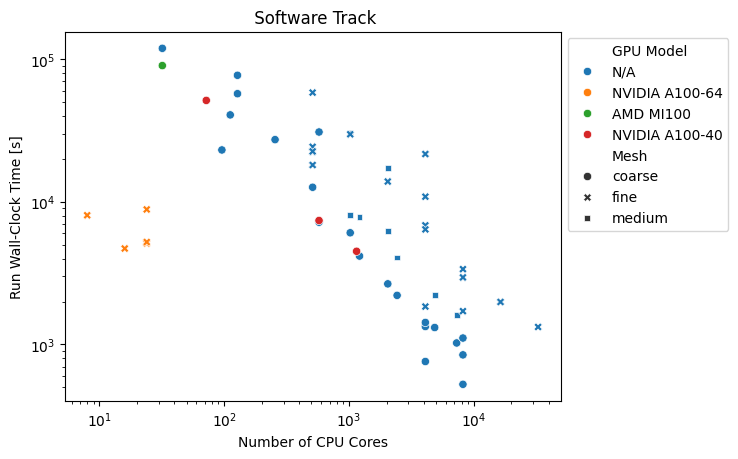

In [36]:
ax = sb.scatterplot(df_software,x="Number of CPU Cores", y="Run Wall-Clock Time [s]", hue="GPU Model", style="Mesh")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "wct_cores_GPUModel", doSaveFig)

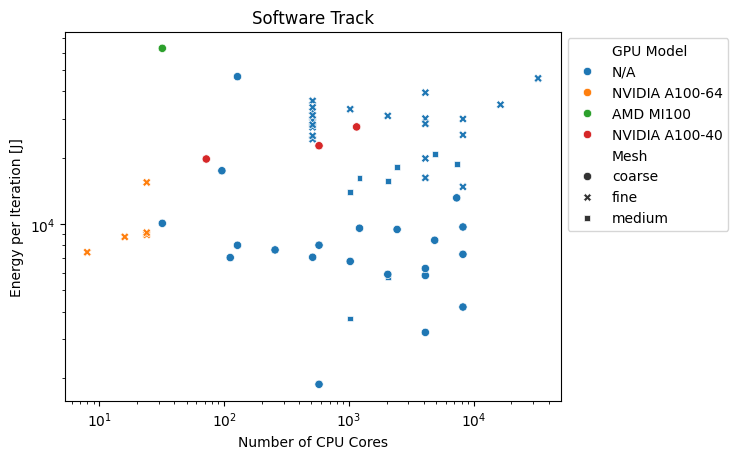

In [37]:
df_software_filt = df_software
ax = sb.scatterplot(df_software_filt,x="Number of CPU Cores", y="Energy per Iteration [J]", hue="GPU Model", style="Mesh")
ax.set(xscale="log", yscale="log", title="Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "EnergyPerIteration_cores_GPUModel", doSaveFig)

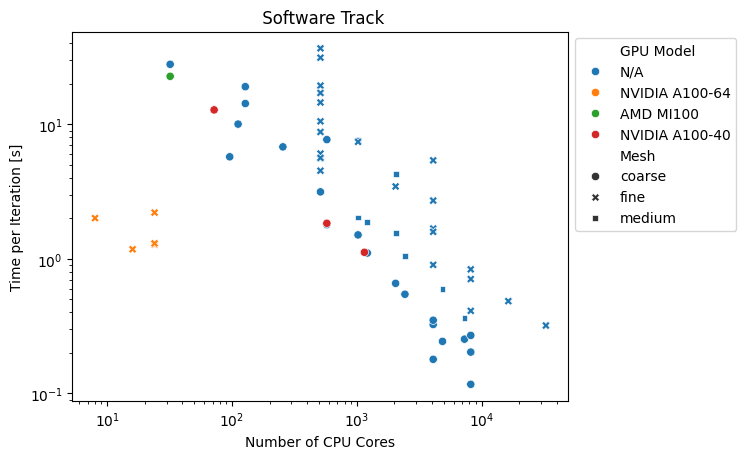

In [38]:
ax = sb.scatterplot(df_software,x="Number of CPU Cores", y="Time per Iteration [s]", hue="GPU Model", style="Mesh")
ax.set(xscale="log", yscale="log", title=" Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "TimePerIteration_cores_GPUModel", doSaveFig)

# Aerodynamic Coefficients

/tmp/ipykernel_893593/2364517994.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(
/tmp/ipykernel_893593/2364517994.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(
/tmp/ipykernel_893593/2364517994.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(


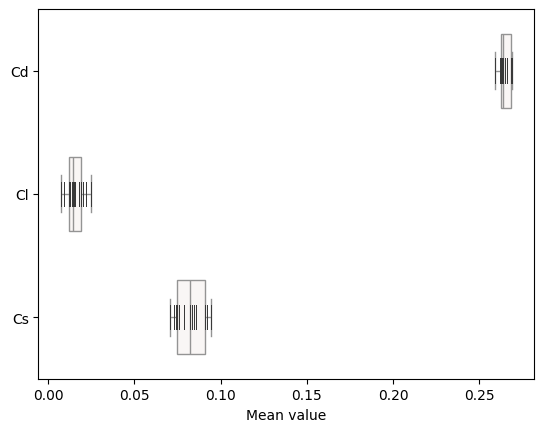

In [39]:
dsfs_clean = dfsf.dropna()
dsfs_clean = dsfs_clean[dsfs_clean["Contributor Affiliation"] != "CFD FEA SERVICE SRL"]
dsfs_clean["Cd mean"] = "Cd"
dsfs_clean["Cl mean"] = "Cl"
dsfs_clean["Cs mean"] = "Cs"

sb.boxplot(
    dsfs_clean, x="cd_mean", y="Cd mean",
    whis=[0, 100], width=.6, palette="vlag"
)
sb.boxplot(
    dsfs_clean, x="cl_mean", y="Cl mean",
    whis=[0, 100], width=.6, palette="vlag"
)
sb.boxplot(
    dsfs_clean, x="cs_mean", y="Cs mean",
    whis=[0, 100], width=.6, palette="vlag"
)
sb.stripplot(dsfs_clean, x="cd_mean", y="Cd mean", size=0.5, color=".3")
sb.stripplot(dsfs_clean, x="cl_mean", y="Cl mean", size=0.5, color=".3")
ax = sb.stripplot(dsfs_clean, x="cs_mean", y="Cs mean", size=0.5, color=".3")

ax.set(xlabel='Mean value', ylabel='')

fig = ax.get_figure()

/tmp/ipykernel_893593/2755085759.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(
/tmp/ipykernel_893593/2755085759.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["Cd"], size = 15)
/tmp/ipykernel_893593/2755085759.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 15)


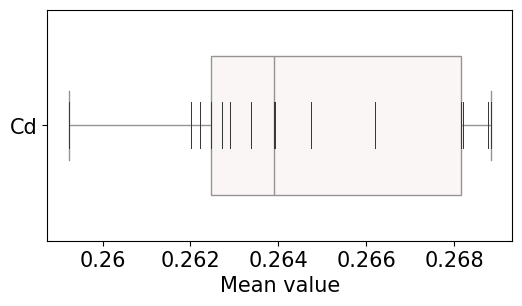

In [40]:

sb.boxplot(
    dsfs_clean, x="cd_mean", y="Cd mean",
    whis=[0, 100], width=.6, palette="vlag"
)
ax = sb.stripplot(dsfs_clean, x="cd_mean", y="Cd mean", size=0.5, color=".3")

ax.set_xlabel('Mean value', fontsize=15)
ax.set_ylabel('')
ax.set_yticklabels(["Cd"], size = 15)
ax.set_xticklabels(ax.get_xticks(), size = 15)

fig = ax.get_figure()
fig.set_size_inches(6, 3)

/tmp/ipykernel_893593/292379111.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(
/tmp/ipykernel_893593/292379111.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["Cl"], size = 15)
/tmp/ipykernel_893593/292379111.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 15)


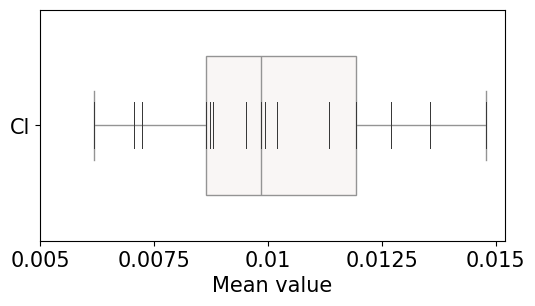

In [41]:
sb.boxplot(
    dsfs_clean, x="cl_mean", y="Cl mean",
    whis=[0, 100], width=.6, palette="vlag",
)
ax = sb.stripplot(dsfs_clean, x="cl_mean", y="Cl mean", size=0.5, color=".3")

ax.set_xlabel('Mean value', fontsize=15)
ax.set_ylabel('')
ax.set_yticklabels(["Cl"], size = 15)
ax.set_xticklabels(ax.get_xticks(), size = 15)
ax.set_xticks(ax.get_xticks()[::2]);            # show every 2th tick

fig = ax.get_figure()
fig.set_size_inches(6, 3)

/tmp/ipykernel_893593/2441014139.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(
/tmp/ipykernel_893593/2441014139.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["Cs"], size = 15)
/tmp/ipykernel_893593/2441014139.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), size = 15)


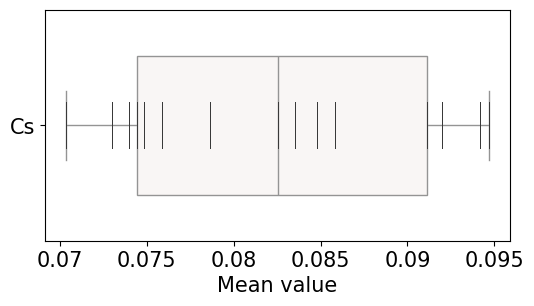

In [42]:
sb.boxplot(
    dsfs_clean, x="cs_mean", y="Cs mean",
    whis=[0, 100], width=.6, palette="vlag"
)
ax = sb.stripplot(dsfs_clean, x="cs_mean", y="Cs mean", size=0.5, color=".3")

ax.set_xlabel('Mean value', fontsize=15)
ax.set_ylabel('')
ax.set_yticklabels(["Cs"], size = 15)
ax.set_xticklabels(ax.get_xticks(), size = 15)

fig = ax.get_figure()
fig.set_size_inches(6, 3)